# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer
# magic word for producing visualizations in notebook
%matplotlib inline
from sklearn.cluster import KMeans
'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep =';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep =';' )

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape


(891221, 85)

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [8]:

feat_info.shape

(85, 4)

In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat_info.info

<bound method DataFrame.info of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [11]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info.missing_or_unknown.value_counts(dropna=False)

[-1]        26
[-1,9]      17
[-1,0]      16
[0]         12
[]          10
[-1,0,9]     1
[-1,X]       1
[XX]         1
[-1,XX]      1
Name: missing_or_unknown, dtype: int64

In [12]:
#Missing before 
total_missing =azdias.isnull().sum().sum()
total_missing

4896838

In [13]:
azdias.isnull().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [14]:
#replace missing with nan 
#code curtesy of mentor 
for index in feat_info.index:
    feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
    azdias.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)

In [15]:
azdias.head(5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [16]:
azdias.isnull().sum()

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [17]:
# Missing values after update
updated_total_missing = azdias.isnull().sum().sum()
updated_total_missing

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

missing_cols = (azdias.isnull().sum()/len(azdias))*100
missing_cols


AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

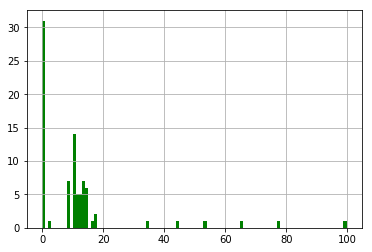

In [19]:
# Investigate patterns in the amount of missing data in each column.
missing_cols.hist(bins=100, color = 'green')




In [20]:
missing_columns = azdias.isnull().sum()
missing_columns

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

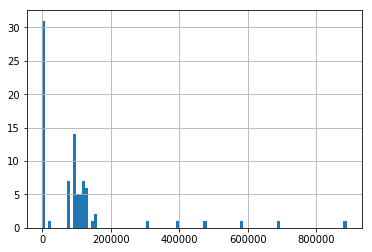

In [21]:
missing_columns.hist(bins=100)

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# identifyiong columns with missing more than 20% data to remove them 
outlier_cols = missing_cols[missing_cols > 20]
cols_drop  = outlier_cols.index.tolist()

print(outlier_cols)
cols_drop


AGER_TYP        76.955435
GEBURTSJAHR     44.020282
TITEL_KZ        99.757636
ALTER_HH        34.813699
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
dtype: float64


['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [23]:
#Remove Outlier columns 

azdias_new = azdias.drop(cols_drop, axis=1)
azdias_new.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [24]:
azdias_new.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

In this section Missing value in columns were assessed and first step was to replace missing and unknown values with NaN. After analysing the data the range of missing data was from 76% to 53% as shown in the figures. So the columns missing more than 20% which added up 6 columns were considered as outliers and hence removed from the dataset.The removed columns were:
AGER_TYP, GEBURTSJAHR, TITEL_KZ, ALTER_HH, KK_KUNDENTYP, KBA05_BAUMAX



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [25]:
# How much data is missing in each row of the dataset?
missing_rows = azdias_new.isnull().sum(axis=1)
missing_rows.describe()




count    891221.000000
mean          5.649894
std          13.234687
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
dtype: float64

In [26]:
missing_rows.sum()

5035304

In [27]:
missing_rows.count()


891221

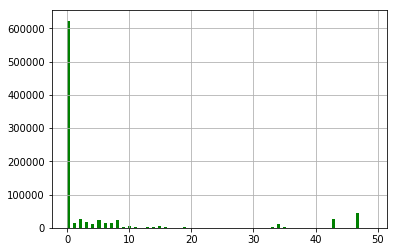

In [28]:
missing_rows.hist(bins=100, color = 'green')

In [29]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
azdias_split1= azdias_new[missing_rows < 30]
azdias_split2 = azdias_new[missing_rows >=30]



In [30]:
azdias_split2.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
azdias_split2.shape

(93160, 79)

In [32]:
azdias_split1.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


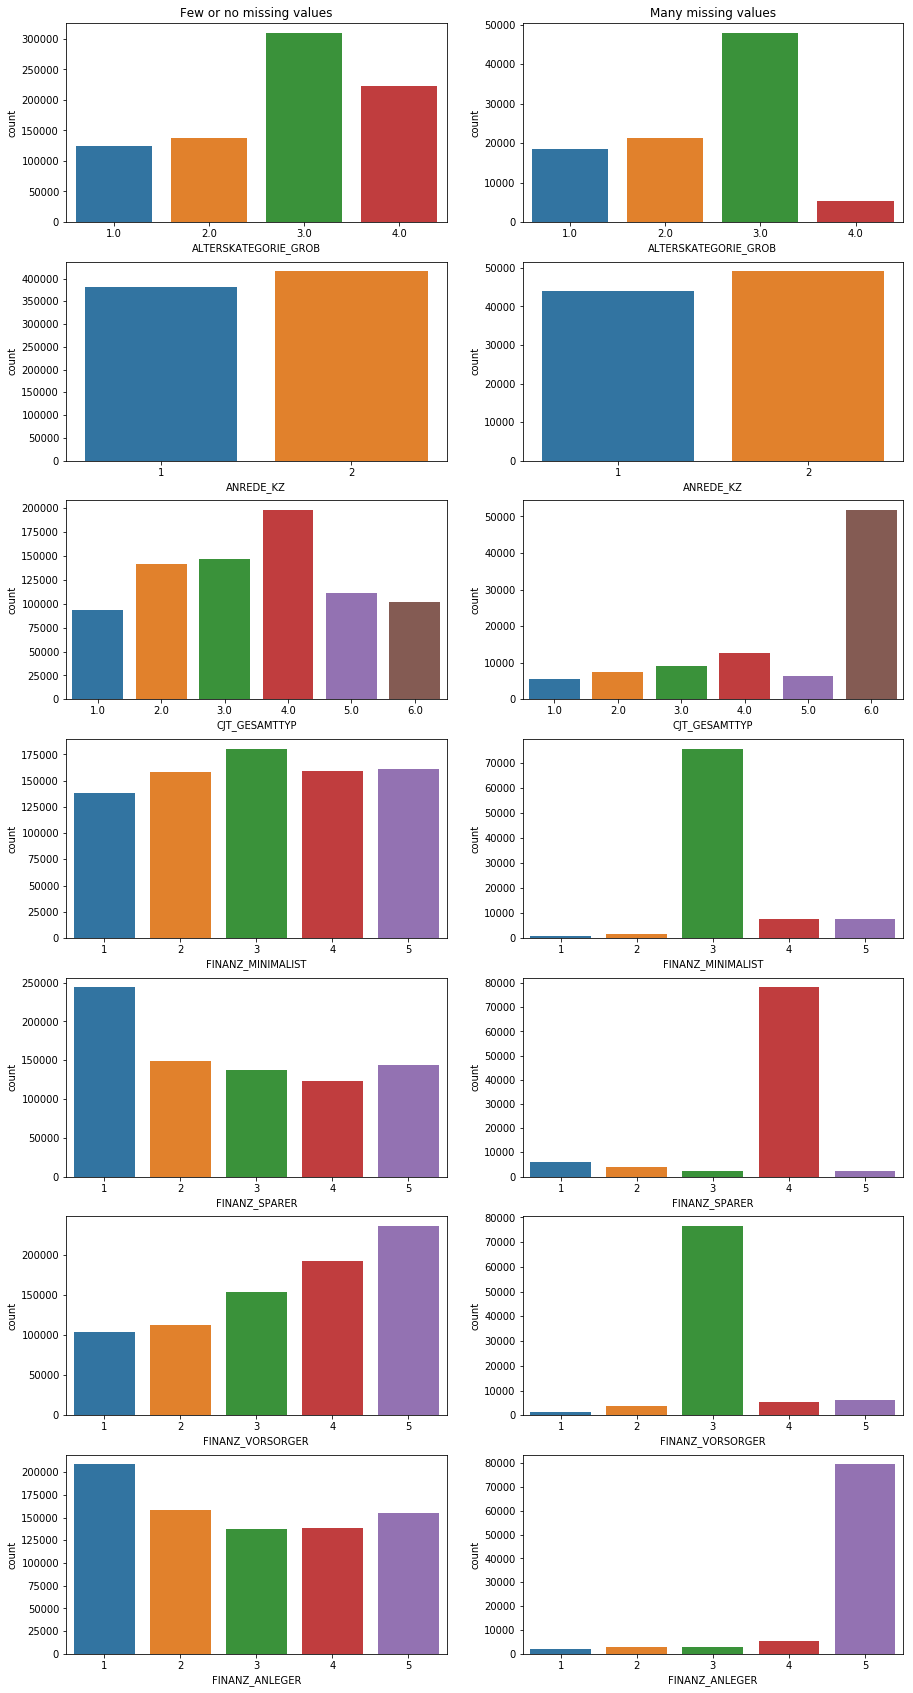

In [33]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(15,30), squeeze=False)
n=0

for cols in azdias_new.columns[:7]:
    sns.countplot(x=cols, data=azdias_split1, ax=axes[n,0])
    axes[0,0].set_title('Few or no missing values')
    sns.countplot(x=cols, data=azdias_split2, ax=axes[n,1])
    axes[0,1].set_title('Many missing values')
    n+=1
    

Graph Visualization [Reference](https://github.com/chauhan-nitin/Udacity-IdentifyCustomerSegments-Arvato/blob/master/Identify_Customer_Segments.ipynb)



In [34]:
azdias_low_missing = azdias_split1

In [35]:
azdias_low_missing.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,2.0,2,5.0,1,5,1,5,4,3,4,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,1.0,1,3.0,3,3,4,1,3,2,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,3.0,1,3.0,4,4,2,4,2,2,6,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,3.0,2,4.0,2,4,2,3,5,4,1,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0
10,3.0,2,1.0,2,2,5,3,1,5,6,...,2.0,4.0,2.0,0.0,2.0,3.0,3.0,4.0,6.0,5.0


In [36]:
azdias_low_missing.shape

(798061, 79)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Graph Visualization [Reference](https://github.com/chauhan-nitin/Udacity-IdentifyCustomerSegments-Arvato/blob/master/Identify_Customer_Segments.ipynb)

In this section dataset was divided into two subsets on the basis of missing values in the rows. subset one (azdias_split1) contained data with missing less than 30 and subset two (azdias_split2) with missing more than 30. As we can see from the visualisation and from analysis that not many rows have 30 or more missing values and hence the ones with 30 or more were dropped from the dataset and was tored under new variable "azdias_low_missing". 




### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [37]:
# How many features are there of each data type?
features = feat_info.groupby('type').count()
print(features)
feat_info.type.value_counts()


             attribute  information_level  missing_or_unknown
type                                                         
categorical         21                 21                  21
interval             1                  1                   1
mixed                7                  7                   7
numeric              7                  7                   7
ordinal             49                 49                  49


ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [38]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values

categorical

array(['AGER_TYP', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ',
       'VERS_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP',
       'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'], dtype=object)

In [39]:
# this code 
#binary = []
#multi_level =[]

#for x in categorical:
   # if x in list(azdias_low_missing.columns):
       #if azdias_low_missing[x].nunique()==2:
          #  binary.append([x])
       # elif azdias_low_missing[x].nunique()>2:
          #  multi_level.append([x])
       # else:
         #   continue
            


            

In [37]:
#binary

In [38]:
#multi_level

In [39]:
#azdias_low_missing[categorical].nunique()

In [39]:
categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute'].values
categorical_features = [x for x in categorical_features if x in azdias_new.columns] # only the ones that are kept in azdias dataset
binary_cols = [x for x in categorical_features if azdias_low_missing[x].nunique()==2]
multilevel = [x for x in categorical_features if azdias_low_missing[x].nunique()>2]
azdias_low_missing[categorical_features].nunique()

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          7
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

 [code curtesy](https://github.com/chauhan-nitin/Udacity-IdentifyCustomerSegments-Arvato/blob/master/Identify_Customer_Segments.ipynb)

In [40]:
azdias_low_missing[binary_cols].head(5)

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,W
2,2,1,0.0,1.0,W
3,2,0,0.0,1.0,W
4,1,0,0.0,2.0,W
5,2,0,0.0,2.0,W


In [41]:
azdias_low_missing['OST_WEST_KZ'].value_counts(dropna=False)

W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64

In [42]:
azdias_low_missing['OST_WEST_KZ'] = azdias_low_missing['OST_WEST_KZ'].replace({'O':0.0, 'W':1.0})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [43]:
azdias_low_missing['OST_WEST_KZ'].value_counts(dropna=False)

1.0    629520
0.0    168541
Name: OST_WEST_KZ, dtype: int64

In [44]:
azdias_low_missing[binary_cols].head(5)

,ANREDE_KZ,GREEN_AVANTGARDE,SOHO_KZ,VERS_TYP,OST_WEST_KZ
1,2,0,1.0,2.0,1.0
2,2,1,0.0,1.0,1.0
3,2,0,0.0,1.0,1.0
4,1,0,0.0,2.0,1.0
5,2,0,0.0,2.0,1.0


In [45]:
azdias_low_missing[multilevel].head(5)

,CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,ZABEOTYP,GEBAEUDETYP,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,5.0,1,10.0,5.0,3.0,2.0,1.0,1.0,3.0,5,8.0,8,8A
2,3.0,1,10.0,1.0,1.0,3.0,2.0,1.0,2.0,5,1.0,4,4C
3,2.0,6,1.0,NaN,NaN,9.0,4.0,1.0,1.0,3,1.0,2,2A
4,5.0,5,5.0,10.0,5.0,3.0,2.0,1.0,2.0,4,1.0,6,6B
5,2.0,2,1.0,1.0,1.0,4.0,2.0,1.0,0.0,4,1.0,8,8C


In [46]:
azdias_low_missing['CAMEO_DEU_2015'].value_counts(dropna=False)

6B     56672
8A     52438
4C     47819
2D     35074
3C     34768
7A     34399
3D     34305
8B     33434
4A     33154
8C     30993
9D     28593
9B     27676
9C     24987
7B     24503
9A     20542
2C     19422
8D     17576
6E     16107
2B     15485
5D     14943
6C     14820
2A     13249
5A     12213
1D     11909
1A     10850
3A     10543
5B     10354
5C      9935
7C      9065
4B      9047
4D      8570
3B      7160
6A      6810
9E      6379
NaN     6198
6D      6073
6F      5392
7D      5333
4E      5321
1E      5065
7E      4633
1C      4317
5F      4283
1B      4071
5E      3581
Name: CAMEO_DEU_2015, dtype: int64

In [47]:
multilevel

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [48]:
# Re-encode categorical variable(s) to be kept in the analysis.
cols = multilevel
azdias_clean = azdias_low_missing.drop(cols, axis=1)

In [49]:
azdias_clean.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,1,5,2,5,4,5,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [50]:
azdias_clean.shape

(798061, 66)

In [52]:
#cols = multilevel

In [53]:
#multilevel.remove('CAMEO_DEU_2015')

In [54]:

#azdias_low_missing = azdias_low_missing.drop(['CAMEO_DEU_2015'], axis=1)

In [55]:
#azdias_encoded = pd.get_dummies(azdias_low_missing, columns=cols)

In [56]:
#azdias_encoded.head(5)

In [57]:
#azdias_encoded.shape

#### Discussion 1.2.1: Re-Encode Categorical Features

In this section we analysed the categorical data in two ways. One with binary categorical data and multilevel categorical data. 
There are 5 columns with binray data and out of which OST_WEST_KZ had non-numeric data which was changed into numeric binary. 
In multilevel categoriers I have decided to drop all the data as it created too many features with less impact on the results

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [51]:
# Identify mixed features

mixed = feat_info[feat_info['type'] == 'mixed']['attribute'].values
mixed



array(['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_BAUMAX', 'PLZ8_BAUMAX'], dtype=object)

In [59]:
#mixed_type = [x for x in mixed if x in azdias_encoded.columns] 

In [52]:
mixed_type = [x for x in mixed if x in azdias_clean.columns] 

In [61]:
#azdias_encoded[mixed_type].head()

In [53]:
azdias_clean[mixed_type].head()

,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,WOHNLAGE,CAMEO_INTL_2015,PLZ8_BAUMAX
1,21.0,6.0,14.0,4.0,51,1.0
2,3.0,1.0,15.0,2.0,24,1.0
3,NaN,NaN,8.0,7.0,12,1.0
4,32.0,10.0,8.0,3.0,43,2.0
5,8.0,2.0,3.0,7.0,54,1.0


In [54]:
azdias_clean['PRAEGENDE_JUGENDJAHRE'].value_counts(dropna=False)

 14.0    182983
 8.0     141630
 10.0     85808
 5.0      84691
 3.0      53845
 15.0     42547
 11.0     35752
 9.0      33570
NaN       28755
 6.0      25652
 12.0     24446
 1.0      20678
 4.0      20451
 2.0       7479
 13.0      5764
 7.0       4010
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [55]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
Movement =[]
Decade=[]
for values in azdias_clean['PRAEGENDE_JUGENDJAHRE']:
    #Mapping to Movement
    if values in [1.0,3.0,5.0,8.0,10.0,12.0,14.0]:
        Movement.append(0.0)
    elif values in [2.0,4.0,6.0,7.0,9.0,11.0,13.0,15.0]:
        Movement.append(1.0)
    else:
        Movement.append(np.nan)
    #Maping to Decade
    if values in [1.0,2.0]:
        Decade.append(40.0)
    elif values in [3.0, 4.0]:
        Decade.append(50.0)
    elif values in [5.0,6.0,7.0]:
        Decade.append(60.0)
    elif values in [8.0,9.0]:
        Decade.append(70.0)
    elif values in [10.0,11.0,12.0,13.0]:
        Decade.append(80)
    elif values in [14.0,15.0]:
        Decade.append(90)
    else:
        Decade.append(np.nan)
        

In [56]:
azdias_clean['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = Movement

In [57]:
azdias_clean['PRAEGENDE_JUGENDJAHRE_DECADE'] = Decade

In [58]:
azdias_clean.tail(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE
891216,3.0,2,1,4,2,5,4,4,0,3.0,...,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN,0.0,90.0
891217,2.0,1,3,3,3,2,2,3,0,NaN,...,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0,0.0,80.0
891218,2.0,2,2,4,2,5,4,3,0,1.0,...,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0,0.0,90.0
891219,1.0,1,1,5,3,5,5,5,0,1.0,...,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0,0.0,90.0
891220,4.0,1,4,2,5,2,1,5,0,2.0,...,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0,0.0,50.0


In [59]:
azdias_clean.shape

(798061, 68)

In [60]:
azdias_clean = azdias_clean.drop(['PRAEGENDE_JUGENDJAHRE'], axis=1)

In [61]:
azdias_clean.shape

(798061, 67)

In [62]:
azdias_clean['CAMEO_INTL_2015'] = pd.to_numeric(azdias_clean['CAMEO_INTL_2015'], errors = 'coercion')

In [63]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
Wealth =[]
Life_Stage =[]
for values in azdias_clean['CAMEO_INTL_2015']:
    
    #Maping for Wealthy 
    if values in [11,12,13,14,15]:
        Wealth.append(5.0)
    elif values in [21,22,23,24,25]:
        Wealth.append(4.0)
    elif values in [31,32,33,34,35]:
        Wealth.append(3.0)
    elif values in [41,42,43,44,45]:
        Wealth.append(2.0)
    elif values in [51,52,53, 54, 55]:
        Wealth.append(1.0)
    else:
        Wealth.append(np.nan)
    #Maping Life Stage
        #Maping Life Stage
    if values in [11,21,31,41,51]:
        Life_Stage.append(1.0)
    elif values in [12,22,32,42,52]:
        Life_Stage.append(2.0)
    elif values in [13,23,33,43,53]:
        Life_Stage.append(3.0)
    elif values in [14,24,34,44,54]:
        Life_Stage.append(4.0)
    elif values in [15,25,35,45,55]:
        Life_Stage.append(5.0)
    else:
        Life_Stage.append(np.nan)

    
    


In [64]:
Wealth

[1.0,
 4.0,
 5.0,
 2.0,
 1.0,
 4.0,
 5.0,
 5.0,
 5.0,
 1.0,
 2.0,
 3.0,
 2.0,
 2.0,
 4.0,
 3.0,
 4.0,
 1.0,
 1.0,
 2.0,
 3.0,
 nan,
 1.0,
 5.0,
 5.0,
 1.0,
 5.0,
 2.0,
 4.0,
 2.0,
 4.0,
 4.0,
 nan,
 nan,
 4.0,
 4.0,
 4.0,
 4.0,
 2.0,
 4.0,
 2.0,
 2.0,
 3.0,
 2.0,
 1.0,
 4.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 2.0,
 1.0,
 4.0,
 4.0,
 4.0,
 2.0,
 3.0,
 2.0,
 2.0,
 2.0,
 4.0,
 2.0,
 4.0,
 2.0,
 3.0,
 5.0,
 3.0,
 5.0,
 5.0,
 2.0,
 3.0,
 4.0,
 1.0,
 2.0,
 4.0,
 1.0,
 5.0,
 5.0,
 4.0,
 4.0,
 1.0,
 4.0,
 2.0,
 1.0,
 5.0,
 1.0,
 4.0,
 4.0,
 4.0,
 3.0,
 2.0,
 1.0,
 5.0,
 4.0,
 4.0,
 5.0,
 5.0,
 3.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.0,
 5.0,
 1.0,
 2.0,
 3.0,
 nan,
 2.0,
 1.0,
 2.0,
 nan,
 nan,
 2.0,
 1.0,
 4.0,
 4.0,
 4.0,
 1.0,
 1.0,
 2.0,
 3.0,
 5.0,
 4.0,
 2.0,
 2.0,
 3.0,
 4.0,
 4.0,
 1.0,
 1.0,
 4.0,
 4.0,
 1.0,
 4.0,
 5.0,
 nan,
 5.0,
 nan,
 1.0,
 nan,
 4.0,
 1.0,
 1.0,
 4.0,
 3.0,
 4.0,
 1.0,
 1.0,
 4.0,
 1.0,
 2.0,
 2.0,
 2.0,
 1.0,
 2.0,
 1.0,
 3.0,
 5.0,
 4.0,
 1.0,
 2.0,
 1.0,
 2.0

In [65]:
Life_Stage

[1.0,
 4.0,
 2.0,
 3.0,
 4.0,
 2.0,
 4.0,
 3.0,
 5.0,
 1.0,
 3.0,
 3.0,
 1.0,
 1.0,
 4.0,
 4.0,
 4.0,
 5.0,
 1.0,
 3.0,
 3.0,
 nan,
 1.0,
 3.0,
 2.0,
 1.0,
 4.0,
 1.0,
 5.0,
 1.0,
 4.0,
 5.0,
 nan,
 nan,
 5.0,
 3.0,
 5.0,
 4.0,
 1.0,
 5.0,
 3.0,
 3.0,
 1.0,
 1.0,
 1.0,
 2.0,
 1.0,
 3.0,
 1.0,
 1.0,
 1.0,
 2.0,
 3.0,
 2.0,
 5.0,
 5.0,
 2.0,
 1.0,
 5.0,
 1.0,
 1.0,
 1.0,
 5.0,
 1.0,
 5.0,
 5.0,
 5.0,
 4.0,
 3.0,
 5.0,
 4.0,
 1.0,
 3.0,
 4.0,
 4.0,
 3.0,
 4.0,
 4.0,
 3.0,
 4.0,
 4.0,
 5.0,
 1.0,
 4.0,
 1.0,
 1.0,
 3.0,
 4.0,
 5.0,
 4.0,
 5.0,
 4.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 4.0,
 5.0,
 4.0,
 5.0,
 1.0,
 1.0,
 4.0,
 1.0,
 3.0,
 4.0,
 1.0,
 1.0,
 1.0,
 nan,
 1.0,
 1.0,
 3.0,
 nan,
 nan,
 1.0,
 1.0,
 5.0,
 4.0,
 4.0,
 4.0,
 4.0,
 1.0,
 2.0,
 5.0,
 4.0,
 3.0,
 4.0,
 3.0,
 4.0,
 4.0,
 4.0,
 4.0,
 4.0,
 3.0,
 1.0,
 2.0,
 3.0,
 nan,
 3.0,
 nan,
 1.0,
 nan,
 4.0,
 1.0,
 5.0,
 4.0,
 4.0,
 4.0,
 1.0,
 1.0,
 5.0,
 1.0,
 3.0,
 1.0,
 5.0,
 1.0,
 1.0,
 1.0,
 1.0,
 3.0,
 5.0,
 4.0,
 3.0,
 1.0,
 5.0

In [66]:
azdias_clean['CAMEO_INTL_WEALTH'] = Wealth
azdias_clean['CAMEO_INTL_LIFE_STAGE'] = Life_Stage

In [67]:
azdias_clean.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,90.0,1.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,1.0,90.0,4.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,0.0,70.0,5.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0.0,70.0,2.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0.0,50.0,1.0,4.0
6,2.0,2,1,5,1,5,4,3,0,2.0,...,1.0,5.0,5.0,4.0,6.0,3.0,0.0,80.0,4.0,2.0
7,1.0,1,3,3,4,1,3,2,0,1.0,...,1.0,4.0,4.0,2.0,5.0,2.0,0.0,70.0,5.0,4.0
8,3.0,1,4,4,2,4,2,2,1,3.0,...,1.0,3.0,3.0,2.0,4.0,3.0,1.0,80.0,5.0,3.0
9,3.0,2,2,4,2,3,5,4,1,2.0,...,1.0,3.0,3.0,2.0,3.0,1.0,1.0,90.0,5.0,5.0
10,3.0,2,2,2,5,3,1,5,0,2.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0.0,50.0,1.0,1.0


In [68]:
azdias_clean['CAMEO_INTL_2015'].head(10)

1     51.0
2     24.0
3     12.0
4     43.0
5     54.0
6     22.0
7     14.0
8     13.0
9     15.0
10    51.0
Name: CAMEO_INTL_2015, dtype: float64

#### Discussion 1.2.2: Engineer Mixed-Type Features
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

PRAEGENDE_JUGENDJAHRE" was to be divided into two variables Movement and Decade based on the above directory. avantgarde vs. mainstream was given the value 0 and 1 respectively for Movement. The two new features were added to the dataset PRAEGENDE_JUGENDJAHRE_MOVEMENT & PRAEGENDE_JUGENDJAHRE_DECADE and PRAEGENDE_JUGENDJAHRE was deleted. 

Similarly CAMEO_INTL_2015 was divided into two variables Wealth and Life Stage based on below data directory and stored as CAMEO_INTL_WEALTH, CAMEO_INTL_LIFE_STAGE. The main variable CAMEO_INTL_2015 was dropped. 

### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [69]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

azdias_clean = azdias_clean.drop(['CAMEO_INTL_2015'], axis=1)

In [70]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
print(azdias_clean.shape)
azdias_clean.head(5)


(798061, 68)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,90.0,1.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,1.0,90.0,4.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,0.0,70.0,5.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0.0,70.0,2.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0.0,50.0,1.0,4.0


In [71]:
azdias_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 798061 entries, 1 to 891220
Data columns (total 68 columns):
ALTERSKATEGORIE_GROB              795258 non-null float64
ANREDE_KZ                         798061 non-null int64
FINANZ_MINIMALIST                 798061 non-null int64
FINANZ_SPARER                     798061 non-null int64
FINANZ_VORSORGER                  798061 non-null int64
FINANZ_ANLEGER                    798061 non-null int64
FINANZ_UNAUFFAELLIGER             798061 non-null int64
FINANZ_HAUSBAUER                  798061 non-null int64
GREEN_AVANTGARDE                  798061 non-null int64
HEALTH_TYP                        761340 non-null float64
LP_LEBENSPHASE_FEIN               747828 non-null float64
LP_LEBENSPHASE_GROB               750721 non-null float64
RETOURTYP_BK_S                    793316 non-null float64
SEMIO_SOZ                         798061 non-null int64
SEMIO_FAM                         798061 non-null int64
SEMIO_REL                         79806

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [72]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep =';' )
    
    # convert missing value codes into NaNs, ...
    
    for index in feat_info.index:
        feat_info.loc[index,'missing_or_unknown'] = feat_info.loc[index,'missing_or_unknown'].strip('[]').split(',')
    for item in range(len(feat_info.loc[index,'missing_or_unknown'])):
        try:
            feat_info.loc[index,'missing_or_unknown'][item] = int(feat_info.loc[index,'missing_or_unknown'][item])
        except:
            continue
    df.loc[:,(feat_info.loc[index, 'attribute'])].replace(feat_info.loc[index,'missing_or_unknown'], np.nan, inplace=True)
    
    # remove selected columns and rows, ...
    
    outlier_cols = ['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    df_new = df.drop(outlier_cols, axis = 1)
    df_clean = df_new[df_new.isnull().sum(axis=1) <30]
    
    categorical = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute'].values
    categorical_features = [x for x in categorical_features if x in df_clean.columns] 
    binary_cols = [x for x in categorical_features if df_clean[x].nunique()==2]
    multilevel = [x for x in categorical_features if df_clean[x].nunique()>2]
    
    df_clean['OST_WEST_KZ'] = df_clean['OST_WEST_KZ'].replace({'O':0.0, 'W':1.0})
    #multilevel.remove('CAMEO_DEU_2015')
    df_encoded = df_clean.drop(multilevel, axis =1)
    #df_encoded = pd.get_dummies(df_clean, columns = multilevel)
    
    # select, re-encode, and engineer column values.
        
    Movement =[]
    Decade=[]
    for values in df_encoded['PRAEGENDE_JUGENDJAHRE']:
        #Mapping to Movement
        if values in [1.0,3.0,5.0,8.0,10.0,12.0,14.0]:
            Movement.append(0.0)
        elif values in [2.0,4.0,6.0,7.0,9.0,11.0,13.0,15.0]:
            Movement.append(1.0)
        else:
            Movement.append(np.nan)
        #Maping to Decade
        if values in [1.0,2.0]:
            Decade.append(40.0)
        elif values in [3.0, 4.0]:
            Decade.append(50.0)
        elif values in [5.0,6.0,7.0]:
            Decade.append(60.0)
        elif values in [8.0,9.0]:
            Decade.append(70.0)
        elif values in [10.0,11.0,12.0,13.0]:
            Decade.append(80)
        elif values in [14.0,15.0]:
            Decade.append(90)
        else:
            Decade.append(np.nan)
            
    df_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = Movement
    df_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = Decade
    
    df_encoded['CAMEO_INTL_2015'] = pd.to_numeric(df_encoded['CAMEO_INTL_2015'], errors = 'coerce')
    
                               
    Wealth =[]
    Life_Stage =[]
    
    for values in df_encoded['CAMEO_INTL_2015']:
            #Maping for Wealthy
            if values in [11,12,13,14,15]:
                Wealth.append(5.0)            
            elif values in [21,22,23,24,25]:
                Wealth.append(4.0)
            elif values in [31,32,33,34,35]:
                Wealth.append(3.0)
            elif values in [41,42,43,44,45]:
                Wealth.append(2.0)
            elif values in [51,52,53,54,55]:
                Wealth.append(1.0)
            else:
                Wealth.append(np.nan)
                                           
            #Maping Life Stage
            if values in [11,21,31,41,51]:
                Life_Stage.append(1.0)
            elif values in [12,22,32,42,52]:
                Life_Stage.append(2.0)
            elif values in [13,23,33,43,53]:
                Life_Stage.append(3.0)
            elif values in [14,24,34,44,54]:
                Life_Stage.append(4.0)
            elif values in [15,25,35,45,55]:
                Life_Stage.append(5.0)
            else:
                Life_Stage.append(np.nan)
                
    df_encoded['CAMEO_INTL_WEALTH'] = Wealth
        
    df_encoded['CAMEO_INTL_LIFE_STAGE'] = Life_Stage
        
    df_clean = df_encoded.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'], axis =1 )
        
    return df_clean

    # select, re-encode, and engineer column values.

    
    # Return the cleaned dataframe.
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [73]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imputer = Imputer(strategy = 'mean')
azdias_clean = pd.DataFrame(imputer.fit_transform(azdias_clean), columns= azdias_clean.columns)


In [74]:
azdias_clean.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0.0,90.0,1.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,1.0,4.0,4.0,3.0,5.0,2.0,1.0,90.0,4.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,1.0,3.0,4.0,2.0,3.0,3.0,0.0,70.0,5.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0.0,70.0,2.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,0.0,50.0,1.0,4.0


In [75]:
azdias_clean.isnull().sum().sum()

0

In [76]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [77]:
azdias_scaled = scaler.fit_transform(azdias_clean)

In [78]:
azdias_scaled= pd.DataFrame(azdias_scaled, columns= azdias_clean.columns)

In [79]:
azdias_scaled[:5]

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
0,-1.766064,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.085947,...,-0.656345,1.445567,0.565109,-0.167286,-0.127707,0.68461,-0.553151,1.165685,-1.191320,-1.266423
1,0.201243,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.085947,...,-0.656345,0.403476,0.565109,-0.167286,-0.127707,-0.78931,1.875397,1.165685,0.865171,0.761985
2,1.184897,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.269817,...,-0.656345,-0.638615,0.565109,-1.170879,-0.998251,-0.05235,-0.553151,-0.232024,1.550667,-0.590287
3,0.201243,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.085947,...,0.039000,-0.638615,-0.347957,0.836306,0.307565,1.42157,-0.553151,-0.232024,-0.505823,0.085849
4,-1.766064,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.085947,...,-0.656345,1.445567,1.478175,-1.170879,-0.998251,-0.05235,-0.553151,-1.629732,-1.191320,0.761985


### Discussion 2.1: Apply Feature Scaling

In this section we imputed missing value with mean and feature scaled by using StandardScaler

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [80]:
# Apply PCA to the data.
from sklearn.decomposition import PCA 
def do_pca(n_components, data):
    pca=PCA(n_components)
    x_pca= pca.fit_transform(data)
    return pca, x_pca


In [81]:
#TESTING PCA
pca, x_pca = do_pca(20, azdias_scaled)

In [82]:
pca.explained_variance_ratio_.sum()

0.77768241088902257

In [83]:
for comp in range(20,60):
    pca, x_pca = do_pca(comp, azdias_scaled)
    if pca.explained_variance_ratio_.sum() >= 0.85:
        break
    
    

In [84]:
#code curtesy Udacity classes
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
    plt.figure(figsize=(11, 7))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    
    ax.plot(ind, cumvals)
    
    #for i in range(num_components):
        #ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
    
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    
    plt.title('Explained Variance Per Principal Component')
    
    
    
    
    
        
    
    
    
    
    
    

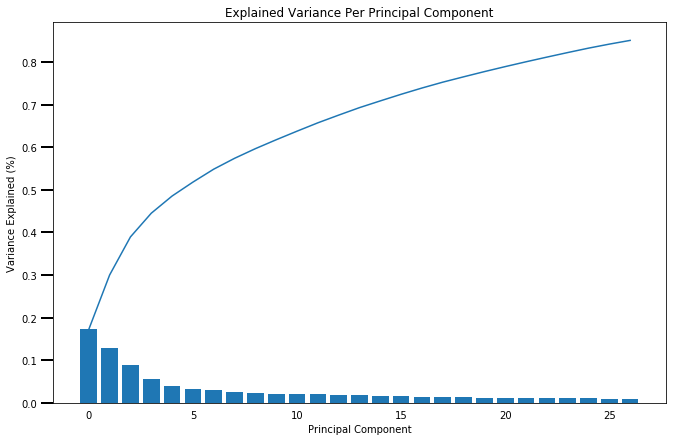

In [85]:
# Investigate the variance accounted for by each principal component.

scree_plot(pca)

In [86]:
# Re-apply PCA to the data while selecting for number of components to retain.
print(pca.n_components)


27


In [87]:
pca.explained_variance_ratio_.sum()

0.85108382674927752

In [88]:
pca=PCA(25)

In [89]:
X_pca = pca.fit_transform(azdias_scaled)

In [90]:
pca.explained_variance_ratio_.sum()

0.83285277754155818

### Discussion 2.2: Perform Dimensionality Reduction

In this section PCA was applied to the data with 20 component for testing the e vectors of variance. After observing around 78% of variance ratio. I further deciced to select the compenents within the range from 20 to 60 to find the 85% or more varience within the data.  The graph showed that it was observed at 27 components. In this case I decided to chose 25 components which constitute almost 83% varience.



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [91]:
def pca_dims(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    '''
    
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

In [92]:
pca_dims(azdias_scaled, pca)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
Dimension 1,0.1725,-0.0871,0.0107,-0.1997,0.1142,-0.0851,0.0419,0.0474,0.1640,-0.1027,...,0.2146,0.0416,-0.1673,0.1418,0.1973,0.1336,-0.1005,0.0703,-0.2016,-0.1181
Dimension 2,0.1277,0.2721,0.0848,0.0949,-0.2522,0.2449,-0.2132,-0.2342,0.0946,0.0011,...,0.0555,0.0080,-0.0492,0.0485,0.0656,0.0469,0.0027,-0.2616,-0.0459,0.0184
Dimension 3,0.0894,0.0772,-0.3692,0.1609,-0.1060,0.0995,-0.1882,-0.0972,-0.0489,0.0537,...,0.0431,0.0034,-0.0347,0.0310,0.0431,0.0282,0.0517,-0.1055,-0.0201,-0.0053
Dimension 4,0.0557,-0.0369,0.0379,0.0644,0.0001,-0.0181,-0.0970,0.0660,-0.1050,0.3510,...,0.0771,0.0956,-0.0051,0.0783,0.2471,0.1072,0.3502,0.0419,0.0993,0.0474
Dimension 5,0.0404,0.0347,-0.0012,0.0379,-0.0001,-0.0230,0.0876,-0.0824,-0.0290,-0.1138,...,0.1003,-0.2948,-0.2864,0.1142,-0.0122,0.0589,-0.1161,0.0175,-0.0834,-0.0452
Dimension 6,0.0327,0.0391,-0.0119,-0.0618,0.0150,0.0526,0.0242,-0.0002,0.0436,-0.1135,...,-0.0143,0.4423,0.2947,-0.1830,-0.0822,-0.1383,-0.1107,0.0013,-0.0697,-0.0740
Dimension 7,0.0304,-0.0065,0.0263,-0.0139,-0.0010,-0.0443,0.0029,-0.0158,0.0226,0.0546,...,0.1009,-0.0826,-0.1259,-0.1714,-0.0830,-0.2042,0.0574,0.0104,0.0916,0.0627
Dimension 8,0.0255,-0.0465,-0.0512,0.0461,0.0318,0.0105,0.0201,0.0387,-0.1379,0.0002,...,-0.0792,0.0738,0.0859,0.0251,0.1586,0.0393,-0.0006,0.0534,0.0428,-0.0024
Dimension 9,0.0227,-0.1075,0.0952,0.0458,-0.1655,0.1870,-0.1269,-0.1621,0.1255,-0.0523,...,-0.0903,0.0051,0.0544,0.0715,0.0668,0.0575,-0.0490,-0.2147,0.0023,0.0683
Dimension 10,0.0209,-0.1089,-0.0239,-0.0234,-0.0332,0.1406,-0.0907,-0.0591,0.0712,-0.0521,...,-0.0302,-0.2160,-0.1034,-0.2455,-0.0777,-0.0828,-0.0531,-0.0480,-0.0364,-0.0712


In [93]:
def pca_results(full_dataset, pca):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    #PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (15,10))
    
    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)
    
    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.03, "Explained Variance\n          %.4f"%(ev))
    
    # Return a concatenated DataFrame
    #return pd.concat([variance_ratios, components], axis = 1)



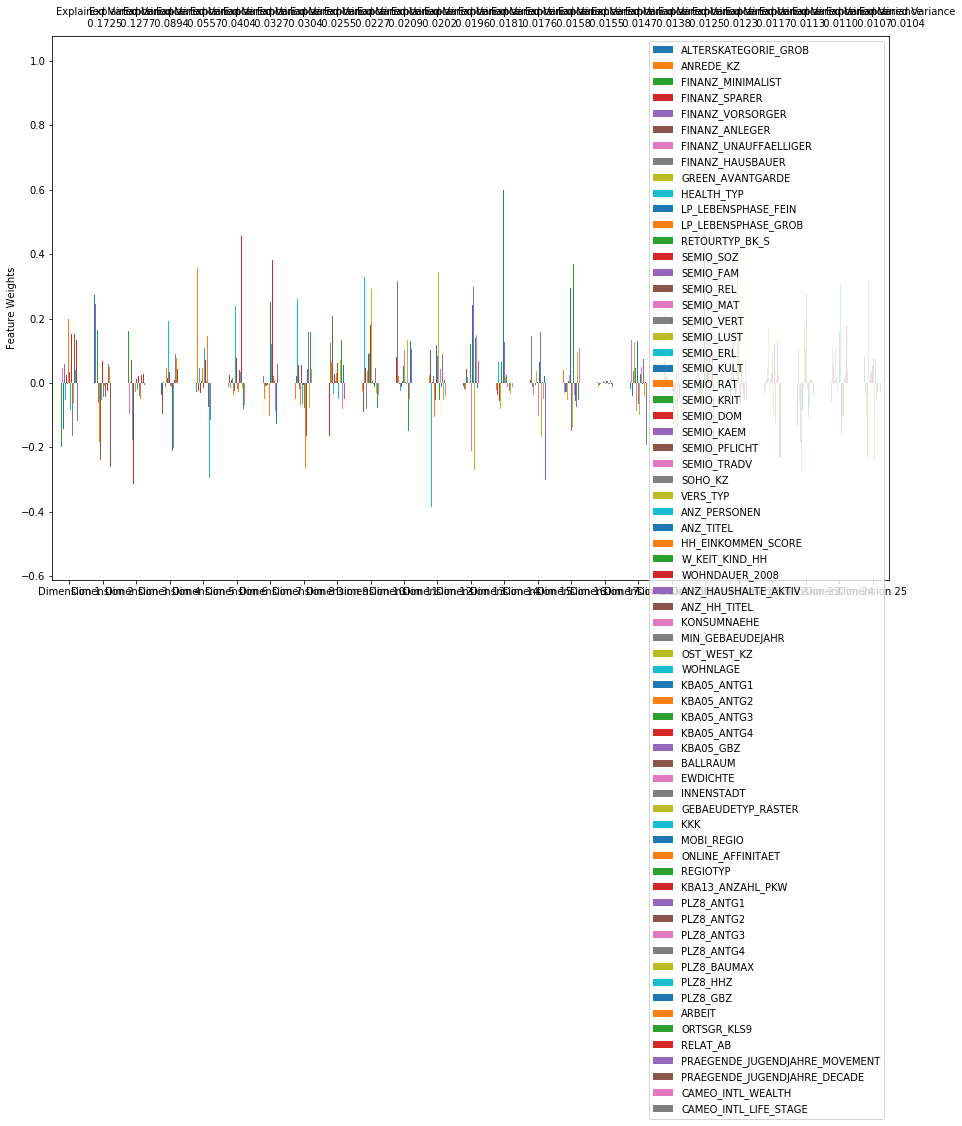

In [94]:
pca_results(azdias_scaled, pca)

In [95]:
data=pd.DataFrame(pca.components_, columns = azdias_scaled.columns)
weights= data.sort_values
display(weights)

<bound method DataFrame.sort_values of     ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0              -0.087060   0.010680          -0.199704       0.114213   
1               0.272141   0.084817           0.094945      -0.252201   
2               0.077206  -0.369229           0.160900      -0.105962   
3              -0.036891   0.037943           0.064401       0.000117   
4               0.034663  -0.001200           0.037868      -0.000093   
5               0.039051  -0.011877          -0.061797       0.015004   
6              -0.006521   0.026262          -0.013889      -0.001031   
7              -0.046485  -0.051201           0.046053       0.031839   
8              -0.107514   0.095213           0.045826      -0.165495   
9              -0.108929  -0.023916          -0.023354      -0.033200   
10             -0.025572   0.003184          -0.169843       0.081900   
11              0.134042   0.023901          -0.184230       0.164295   
12          

In [96]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def pca_weights(item, pca):
    df = pd.DataFrame(pca.components_, columns=azdias_scaled.columns)
    weights = df.iloc[item].sort_values(ascending=False)
    return weights



In [97]:
pca_weights(0,pca)

PLZ8_ANTG3                        0.224910
PLZ8_ANTG4                        0.219204
PLZ8_BAUMAX                       0.214625
ORTSGR_KLS9                       0.197267
HH_EINKOMMEN_SCORE                0.197243
EWDICHTE                          0.195016
FINANZ_HAUSBAUER                  0.163981
PLZ8_ANTG2                        0.152558
KBA05_ANTG4                       0.150784
ARBEIT                            0.141780
ANZ_HAUSHALTE_AKTIV               0.134155
RELAT_AB                          0.133619
KBA05_ANTG3                       0.131040
FINANZ_SPARER                     0.114213
SEMIO_PFLICHT                     0.085456
SEMIO_REL                         0.082341
PRAEGENDE_JUGENDJAHRE_DECADE      0.070294
SEMIO_RAT                         0.069729
REGIOTYP                          0.067991
SEMIO_TRADV                       0.061051
SEMIO_MAT                         0.059207
SEMIO_FAM                         0.059158
W_KEIT_KIND_HH                    0.056814
SEMIO_KULT 

In [98]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weights(1,pca)


ALTERSKATEGORIE_GROB            0.272141
FINANZ_VORSORGER                0.244913
SEMIO_ERL                       0.235270
SEMIO_LUST                      0.190627
RETOURTYP_BK_S                  0.164562
W_KEIT_KIND_HH                  0.116969
SEMIO_KRIT                      0.111553
SEMIO_KAEM                      0.103000
FINANZ_MINIMALIST               0.094945
FINANZ_HAUSBAUER                0.094579
ANREDE_KZ                       0.084817
EWDICHTE                        0.066841
WOHNDAUER_2008                  0.066694
ORTSGR_KLS9                     0.065564
SEMIO_DOM                       0.065247
PLZ8_ANTG3                      0.063056
PLZ8_ANTG4                      0.060073
PLZ8_BAUMAX                     0.055469
ARBEIT                          0.048480
KBA05_ANTG4                     0.047281
RELAT_AB                        0.046893
ANZ_HAUSHALTE_AKTIV             0.044333
PLZ8_ANTG2                      0.043690
VERS_TYP                        0.030466
HH_EINKOMMEN_SCO

In [100]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weights(2,pca)



SEMIO_VERT                        0.346602
SEMIO_SOZ                         0.262597
SEMIO_FAM                         0.250275
SEMIO_KULT                        0.236355
FINANZ_MINIMALIST                 0.160900
RETOURTYP_BK_S                    0.105814
FINANZ_VORSORGER                  0.099540
W_KEIT_KIND_HH                    0.086219
ALTERSKATEGORIE_GROB              0.077206
SEMIO_REL                         0.070513
SEMIO_LUST                        0.063203
SEMIO_MAT                         0.056052
GREEN_AVANTGARDE                  0.053704
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.051656
PLZ8_BAUMAX                       0.043105
ORTSGR_KLS9                       0.043077
EWDICHTE                          0.042150
PLZ8_ANTG4                        0.040734
PLZ8_ANTG3                        0.039692
WOHNDAUER_2008                    0.033765
ARBEIT                            0.031035
RELAT_AB                          0.028217
PLZ8_ANTG2                        0.026163
KBA05_ANTG4

### Discussion 2.3: Interpret Principal Components

#### First Component:

##### First Five Strong Positively Correlated Features 

       1. PLZ8_ANTG3                        
       2. PLZ8_ANTG4                        
       3. PLZ8_BAUMAX                       
       4. ORTSGR_KLS9                      
       5.HH_EINKOMMEN_SCORE                
       
##### First Five Strong Negatively CorrelatedFeatures
                     
       1.MOBI_REGIO
       2.PLZ8_ANTG1
       3.KBA05_ANTG1
       4.KBA05_GBZ
       5.CAMEO_INTL_WEALTH 
 
#### Second Component :

##### First Five Strong Positively Correlated Features 

      1.ALTERSKATEGORIE_GROB
      2.FINANZ_VORSORGER
      3.SEMIO_ERL
      4.SEMIO_LUST
      5.RETOURTYP_BK_S 
      
##### First Five Strong Negatively Correlated  Features
                  
      1.SEMIO_REL 
      2.PRAEGENDE_JUGENDJAHRE_DECADE
      3.FINANZ_SPARER
      4.SEMIO_PFLICHT
      5.SEMIO_TRADV
      
#### Third Component :

##### First Five Strong Positively Correlated Features 

     1.SEMIO_VERT                                      
     2.SEMIO_SOZ
     3.SEMIO_FAM
     4.SEMIO_KULT                        
     5.FINANZ_MINIMALIST   
     
##### First Five Strong Negatively Correlated  Features
     1.ANREDE_KZ                       
     2.SEMIO_KAEM 
     3.SEMIO_DOM        
     4.SEMIO_KRIT
     5.SEMIO_RAT




## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [101]:
# Over a number of different cluster counts...

from sklearn.cluster import KMeans

def kmeans_score(data, clusters):
    '''
    INPUT: data and number of clusters for kmeans
    
    Output: returns the score
    
    '''
    kmeans=KMeans(n_clusters=clusters)
    Model = kmeans.fit(data)
    score = np.abs(Model.score(data))
    
    return score


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
    

In [102]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
score = []

clusters = list(range(3,15))

for cluster in clusters:
    score.append(kmeans_score(X_pca, cluster))

KeyboardInterrupt: 

Text(0,0.5,'Score')

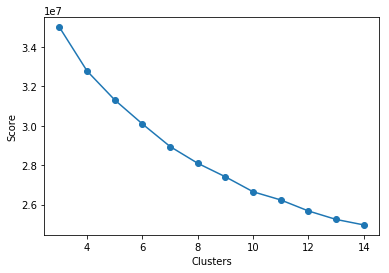

In [121]:
plt.plot(clusters, score, linestyle='-', marker='o')
plt.xlabel('Clusters')
plt.ylabel('Score')

In [103]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans= KMeans(12)
model = kmeans.fit(X_pca)


In [129]:
azdias_pred = model.predict(X_pca)

In [130]:
azdias_pred

array([8, 0, 1, ..., 2, 6, 3], dtype=int32)

### Discussion 3.1: Apply Clustering to General Population

In this section KMeans was applied to PCA-tranformed data 3 to 15 centroid to calculte the score that is the distance between samples and their corresponding centroid. From the graph above I find the centroid between 11 and 14 seems good for our algorithm. On that basis I would go with 12. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [106]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep =';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [107]:
customers['VERS_TYP'].value_counts(dropna=False)

 1    73620
 2    69042
-1    48990
Name: VERS_TYP, dtype: int64

In [108]:
azdias_clean['VERS_TYP'].value_counts(dropna=False)

2.000000    394238
1.000000    367102
1.517821     36721
Name: VERS_TYP, dtype: int64

In [109]:
customers['VERS_TYP']=customers['VERS_TYP'].replace(-1,np.nan)

In [110]:
cust = clean_data(customers)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [111]:
cust.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_MOVEMENT,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_WEALTH,CAMEO_INTL_LIFE_STAGE
0,4,1,5,1,5,1,2,2,1,1,...,1.0,5.0,5.0,1.0,2.0,1.0,1.0,50.0,5.0,3.0
2,4,2,5,1,5,1,4,4,1,2,...,3.0,3.0,2.0,3.0,5.0,3.0,1.0,50.0,3.0,4.0
3,4,1,5,1,5,2,1,2,0,2,...,1.0,3.0,4.0,1.0,3.0,1.0,0.0,40.0,4.0,4.0
4,3,1,3,1,4,4,5,2,0,3,...,2.0,3.0,3.0,3.0,5.0,1.0,0.0,70.0,2.0,1.0
5,3,1,5,1,5,1,2,3,1,3,...,1.0,5.0,5.0,3.0,7.0,5.0,1.0,50.0,3.0,4.0


In [114]:
cust.shape

(141725, 68)

In [115]:
azdias_clean.shape

(798061, 68)

In [116]:
len(cust.columns) == len(azdias_clean.columns)

True

In [117]:
#df['your_column_name'].isin(df2['your_column_name']).value_counts()
cust.columns.isin(azdias_clean.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [118]:
azdias_clean.columns.isin(cust.columns)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [119]:
cust_clean = pd.DataFrame(imputer.fit_transform(cust), columns = cust.columns)

In [120]:
cust_scaled =scaler.fit_transform(cust_clean)

In [121]:
cust_scaled = pd.DataFrame(cust_scaled, columns = cust_clean.columns)

In [122]:
 y_pca = pca.fit_transform(cust_scaled)

In [131]:
cust_pred = model.predict(y_pca)

In [132]:
cust_pred

array([2, 7, 0, ..., 1, 4, 9], dtype=int32)

In [125]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.



### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Population Clusters')

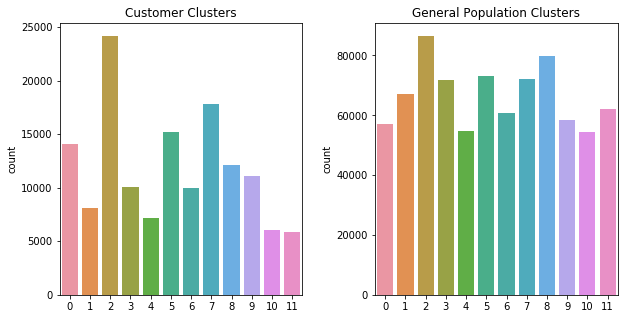

In [133]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)



sns.countplot(cust_pred, ax=axs[0])
axs[0].set_title('Customer Clusters')

sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Population Clusters')

In [134]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_8 = StandardScaler().inverse_transform(pca.inverse_transform(model.cluster_centers_[8]))

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.